In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/IPMI-2023


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
%autoreload
bioqic = mre_pinn.data.BIOQICFEMBox('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/fem_box')

Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc


<IPython.core.display.Javascript object>


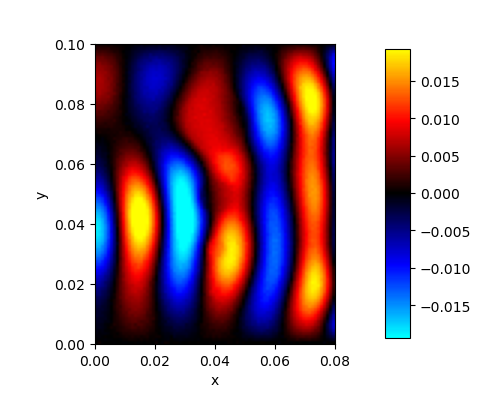

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [3]:
%autoreload
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', 60)
example.add_gaussian_noise(0.001)
example.view('wave', ax_height=3)

In [4]:
example.metadata

size  spacing  origin  limit  center  extent
variable dimension                                              
wave     x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre      x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre_mask x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01

In [5]:
example.describe()

dtype    count                     mean          std  \
variable component                                                              
wave     y          complex128  80000.0  -0.00000100-0.00001100j     0.000759   
         x          complex128  80000.0   0.00022200-0.00020700j     0.000777   
         z          complex128  80000.0   0.00092400+0.00006000j     0.012494   
mre      scalar     complex128  80000.0  3382.375000+376.991118j  1590.727619   
mre_mask scalar          int64  80000.0   1.07650000+0.00000000j     0.362143   

                                        min                      25%  \
variable component                                                     
wave     y          -0.00223600-0.00071300j  -0.00032600+0.00012900j   
         x          -0.00304800+0.00029600j  -0.00010500+0.00000900j   
         z          -0.02344000-0.00261500j  -0.00443300-0.00672500j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                        50%                      75%  \
variable component                                                     
wave     y           0.00002100+0.00006400j   0.00033200+0.00013700j   
         x           0.00019200+0.00021500j   0.00055900+0.00025500j   
         z           0.00069400+0.00228200j   0.00688600+0.00220900j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                         max  
variable component                            
wave     y          0.002076000+0.000623000j  
         x          0.003038000-0.001667000j  
         z          0.023007000+0.003732000j  
mre      scalar     10000.000000+376.991118j  
mre_mask scalar     5.000000000+0.000000000j

Evaluating direct baseline
Evaluating FEM baseline
100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


<IPython.core.display.Javascript object>


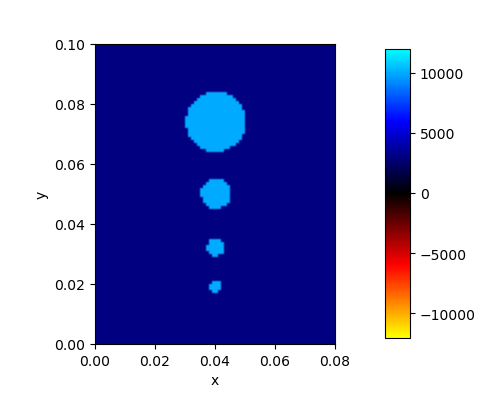

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


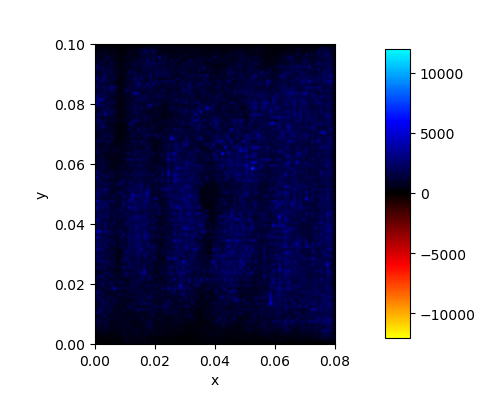

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


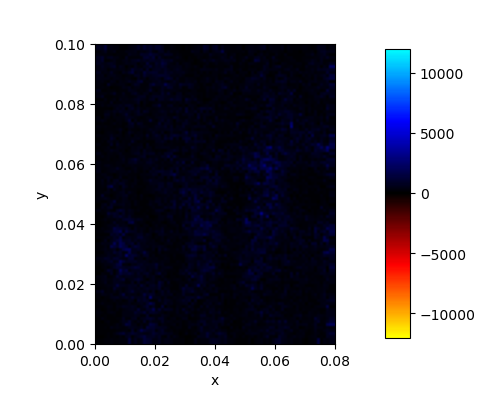

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [8]:
%autoreload
frequency = example.wave.frequency.item()
mre_pinn.baseline.eval_direct_baseline(example, frequency=frequency)
mre_pinn.baseline.eval_fem_baseline(example, frequency=frequency)
example.view('mre', 'direct', 'fem', ax_height=3, polar=True, vmax=12e3)

In [9]:
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=frequency, detach=True)

In [37]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=30,
    n_layers=5,
    n_hidden=128,
    polar_input=False,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (hidden3): Linear(in_features=387, out_features=128, bias=True)
    (output): Linear(in_features=515, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (hidden3): Linear(in_features=387, out_features=128, bias=True)
    (output): Linear(in_features=515, out_features=2, bias=True)
  )
)

In [38]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-6],
    pde_warmup_iters=5000,
    pde_step_iters=5000,
    pde_init_weight=1e-10,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000217 s



In [39]:
%autoreload
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0018s (3.04%)
Model time/iter: 0.0007s (1.16%)
Loss time/iter:  0.0553s (95.80%)
Total time/iter: 0.0577s
Total time: 5.7746s
1k iters time: 0.96m
10k iters time: 9.62m
100k iters time: 1.60h


<IPython.core.display.Javascript object>


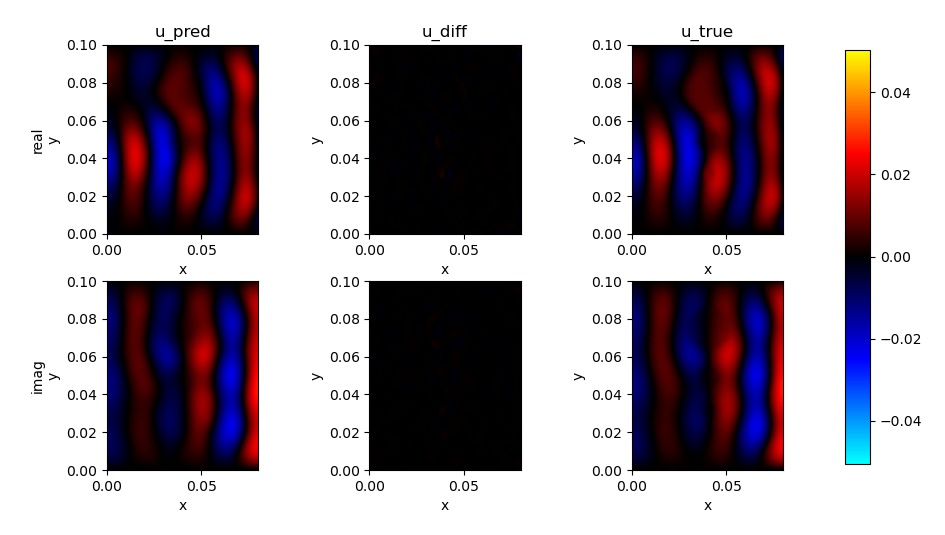

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


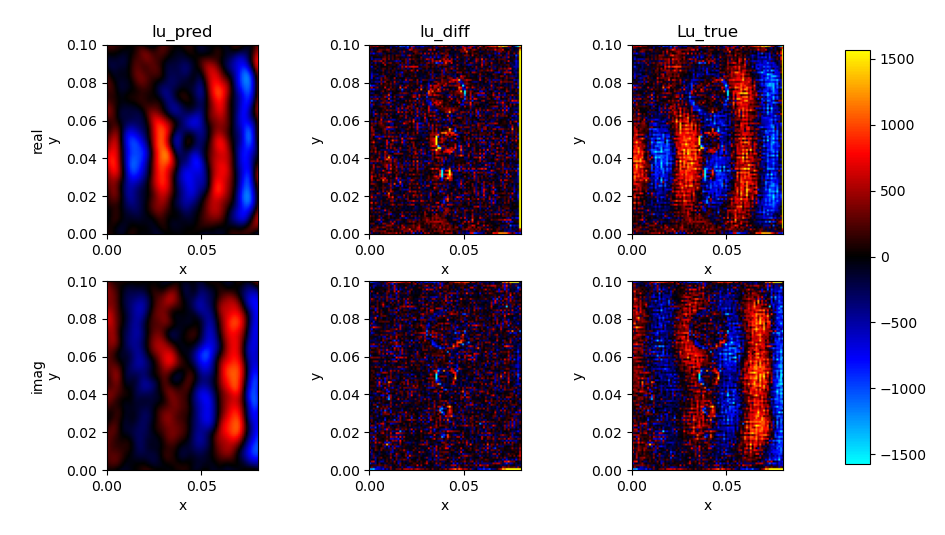

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


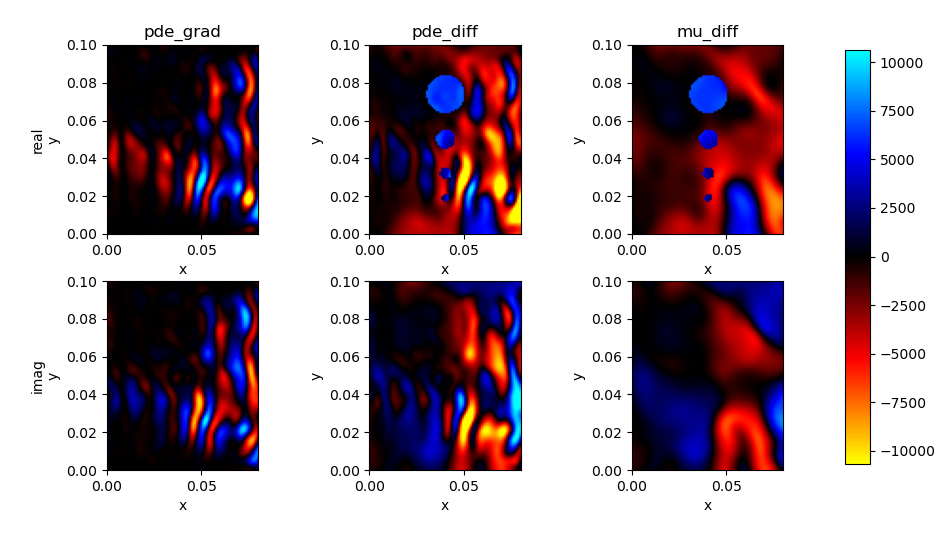

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


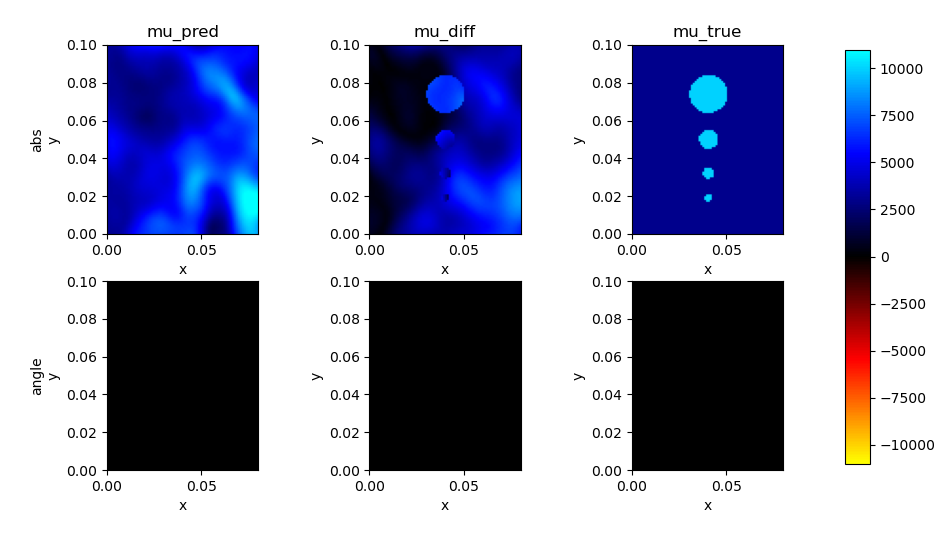

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


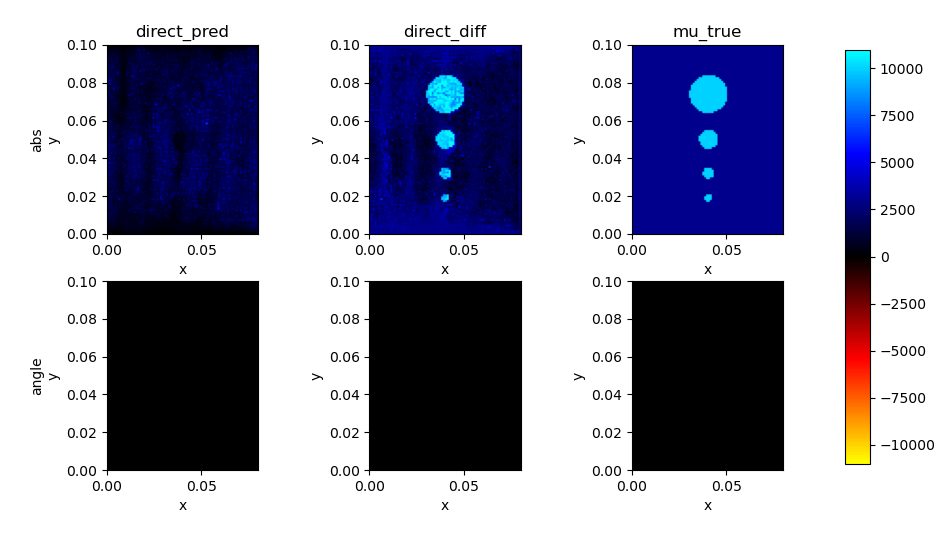

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


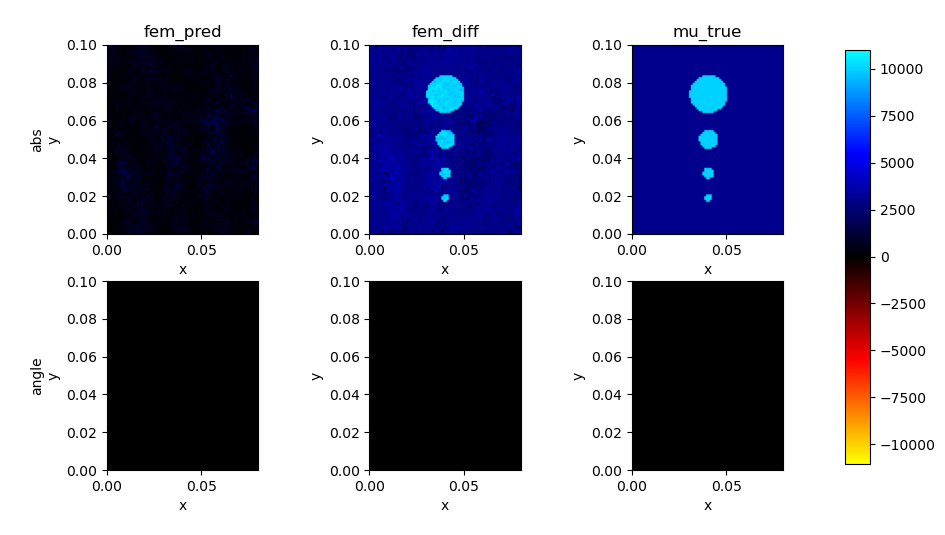

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [42]:
%autoreload
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

Training model...

0         [2.59e-04, 0.00e+00, 0.00e+00]    [2.75e-04, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


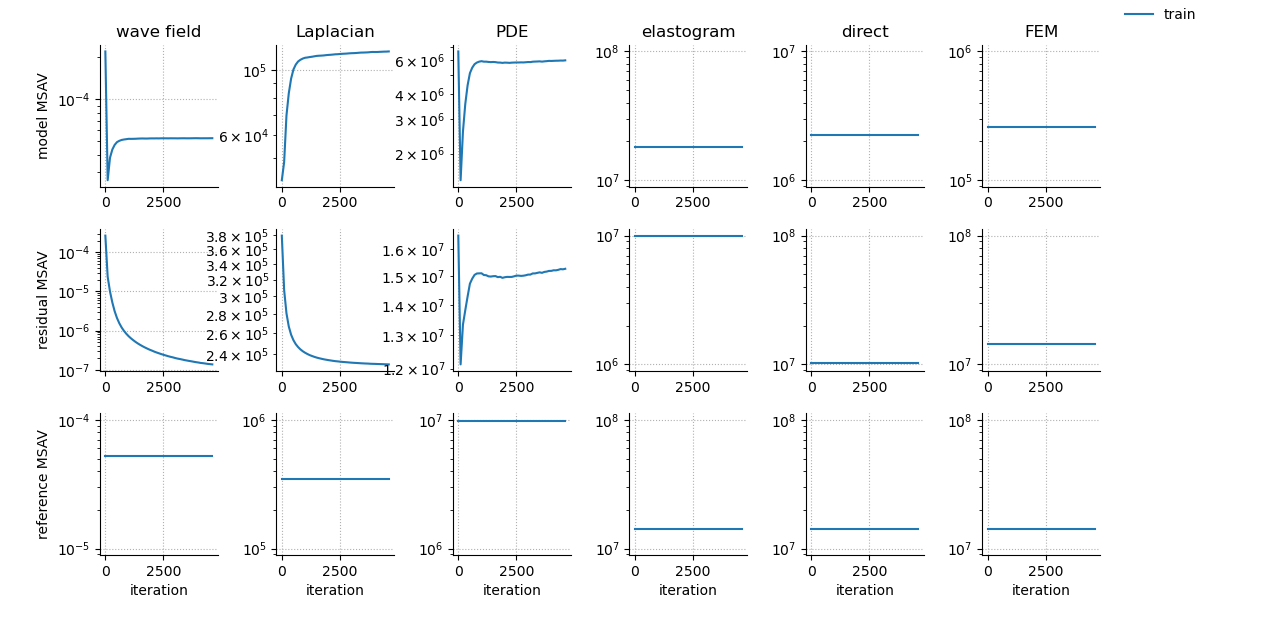

<IPython.core.display.Javascript object>


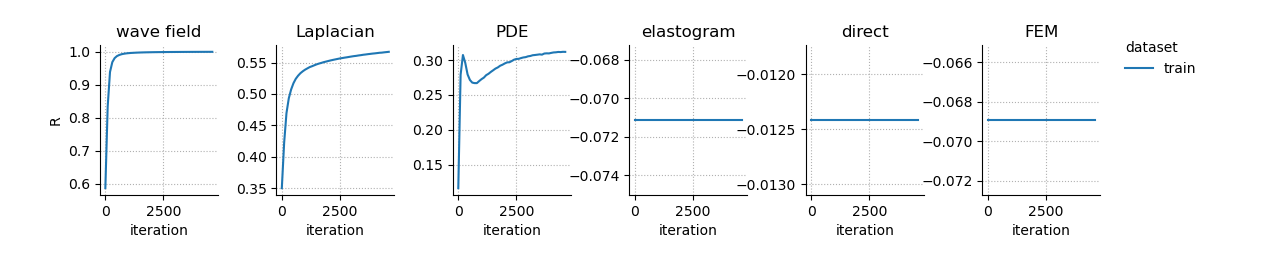

<IPython.core.display.Javascript object>


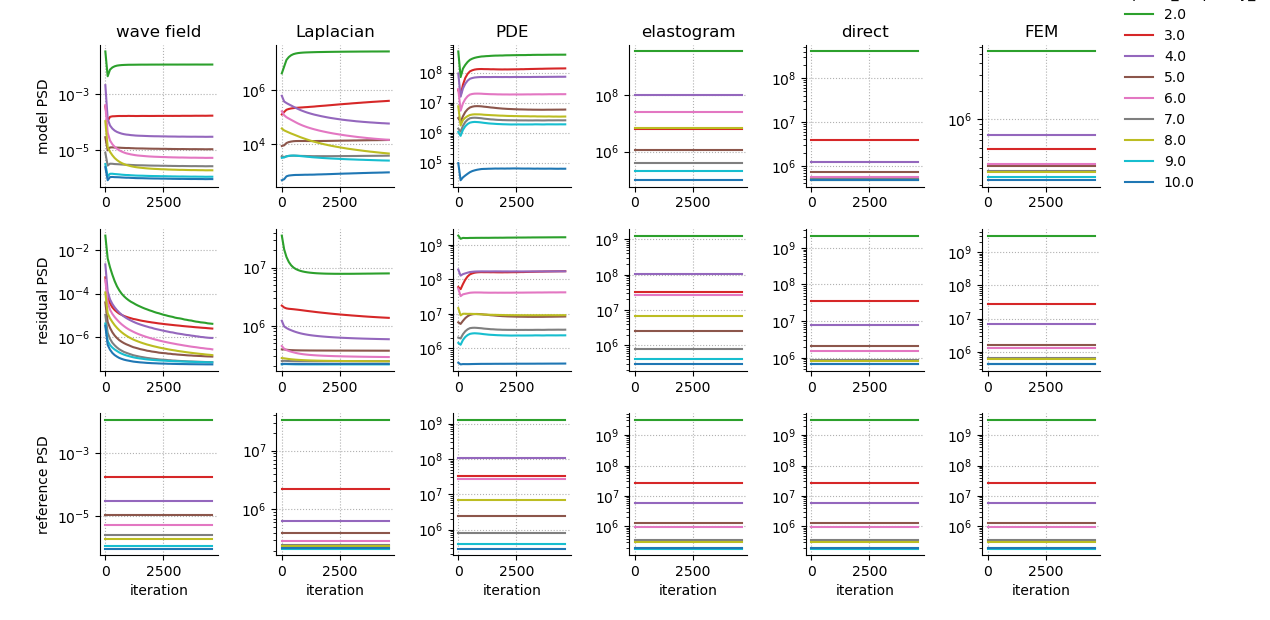

<IPython.core.display.Javascript object>


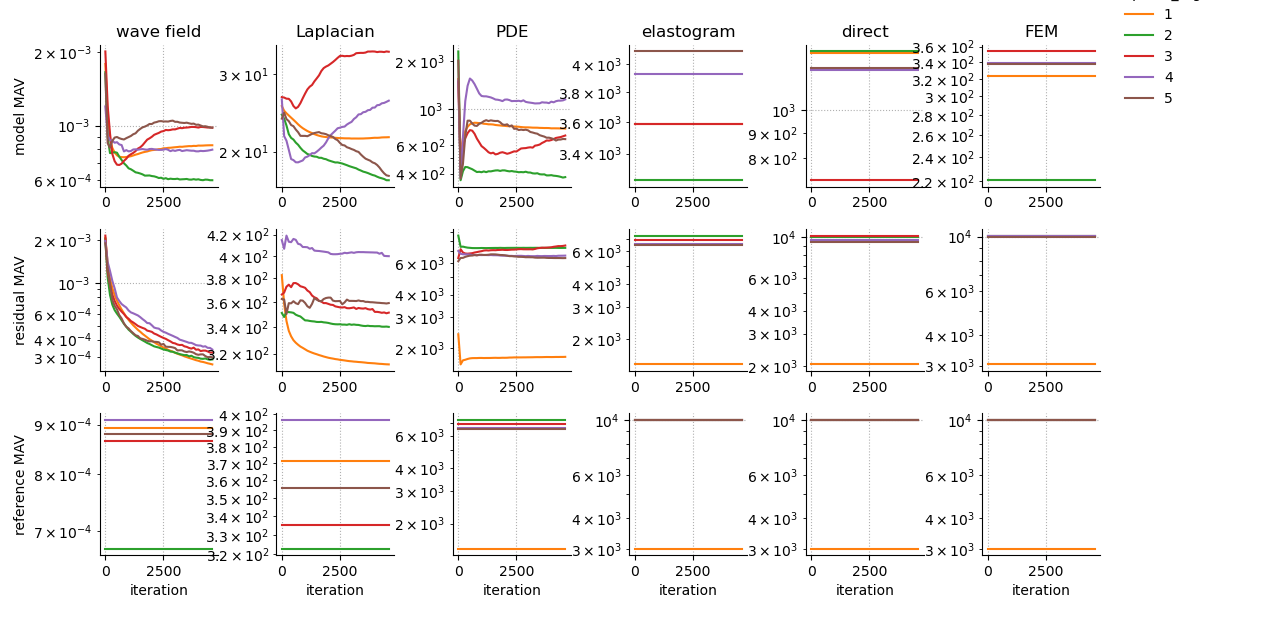

Time spent testing: 22.3345 (20.68%)
10        [1.66e-04, 0.00e+00, 0.00e+00]    [1.71e-04, 0.00e+00, 0.00e+00]    []  
20        [1.03e-04, 0.00e+00, 0.00e+00]    [1.09e-04, 0.00e+00, 0.00e+00]    []  
30        [7.19e-05, 0.00e+00, 0.00e+00]    [7.62e-05, 0.00e+00, 0.00e+00]    []  
40        [5.66e-05, 0.00e+00, 0.00e+00]    [5.90e-05, 0.00e+00, 0.00e+00]    []  
50        [4.90e-05, 0.00e+00, 0.00e+00]    [4.85e-05, 0.00e+00, 0.00e+00]    []  
60        [4.20e-05, 0.00e+00, 0.00e+00]    [4.10e-05, 0.00e+00, 0.00e+00]    []  
70        [3.54e-05, 0.00e+00, 0.00e+00]    [3.52e-05, 0.00e+00, 0.00e+00]    []  
80        [3.04e-05, 0.00e+00, 0.00e+00]    [3.05e-05, 0.00e+00, 0.00e+00]    []  
90        [2.77e-05, 0.00e+00, 0.00e+00]    [2.67e-05, 0.00e+00, 0.00e+00]    []  
100       [2.36e-05, 0.00e+00, 0.00e+00]    [2.36e-05, 0.00e+00, 0.00e+00]    []  
Time spent testing: 18.8769 (30.72%)
110       [2.23e-05, 0.00e+00, 0.00e+00]    [2.10e-05, 0.00e+00, 0.00e+00]    []  
120       [1.

960       [7.18e-07, 0.00e+00, 0.00e+00]    [7.56e-07, 0.00e+00, 0.00e+00]    []  
970       [7.57e-07, 0.00e+00, 0.00e+00]    [7.47e-07, 0.00e+00, 0.00e+00]    []  
980       [7.12e-07, 0.00e+00, 0.00e+00]    [7.34e-07, 0.00e+00, 0.00e+00]    []  
990       [7.33e-07, 0.00e+00, 0.00e+00]    [7.25e-07, 0.00e+00, 0.00e+00]    []  
1000      [7.28e-07, 0.00e+00, 0.00e+00]    [7.17e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 17.7284 (56.37%)
1010      [6.96e-07, 0.00e+00, 0.00e+00]    [7.09e-07, 0.00e+00, 0.00e+00]    []  
1020      [6.60e-07, 0.00e+00, 0.00e+00]    [6.99e-07, 0.00e+00, 0.00e+00]    []  
1030      [6.58e-07, 0.00e+00, 0.00e+00]    [6.87e-07, 0.00e+00, 0.00e+00]    []  
1040      [6.73e-07, 0.00e+00, 0.00e+00]    [6.80e-07, 0.00e+00, 0.00e+00]    []  
1050      [7.15e-07, 0.00e+00, 0.00e+00]    [6.70e-07, 0.00e+00, 0.00e+00]    []  
1060      [6.42e-07, 0.00e+00, 0.00e+00]    [6.61e-07, 0.00e+00, 0.00e+00]    []  
1070      [6.39e-07, 0.00e+00, 0.00e+00]    [6.54e

Time spent testing: 18.9171 (62.11%)
1910      [3.16e-07, 0.00e+00, 0.00e+00]    [3.20e-07, 0.00e+00, 0.00e+00]    []  
1920      [3.09e-07, 0.00e+00, 0.00e+00]    [3.16e-07, 0.00e+00, 0.00e+00]    []  
1930      [3.15e-07, 0.00e+00, 0.00e+00]    [3.15e-07, 0.00e+00, 0.00e+00]    []  
1940      [2.97e-07, 0.00e+00, 0.00e+00]    [3.15e-07, 0.00e+00, 0.00e+00]    []  
1950      [3.17e-07, 0.00e+00, 0.00e+00]    [3.11e-07, 0.00e+00, 0.00e+00]    []  
1960      [3.22e-07, 0.00e+00, 0.00e+00]    [3.11e-07, 0.00e+00, 0.00e+00]    []  
1970      [3.25e-07, 0.00e+00, 0.00e+00]    [3.08e-07, 0.00e+00, 0.00e+00]    []  
1980      [2.90e-07, 0.00e+00, 0.00e+00]    [3.06e-07, 0.00e+00, 0.00e+00]    []  
1990      [3.04e-07, 0.00e+00, 0.00e+00]    [3.06e-07, 0.00e+00, 0.00e+00]    []  
2000      [3.17e-07, 0.00e+00, 0.00e+00]    [3.04e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 19.0898 (62.57%)
2010      [3.09e-07, 0.00e+00, 0.00e+00]    [3.01e-07, 0.00e+00, 0.00e+00]    []  
2020      [2.

2860      [2.10e-07, 0.00e+00, 0.00e+00]    [2.08e-07, 0.00e+00, 0.00e+00]    []  
2870      [2.03e-07, 0.00e+00, 0.00e+00]    [2.06e-07, 0.00e+00, 0.00e+00]    []  
2880      [2.29e-07, 0.00e+00, 0.00e+00]    [2.05e-07, 0.00e+00, 0.00e+00]    []  
2890      [2.21e-07, 0.00e+00, 0.00e+00]    [2.05e-07, 0.00e+00, 0.00e+00]    []  
2900      [2.03e-07, 0.00e+00, 0.00e+00]    [2.03e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 18.3610 (65.23%)
2910      [1.98e-07, 0.00e+00, 0.00e+00]    [2.05e-07, 0.00e+00, 0.00e+00]    []  
2920      [2.20e-07, 0.00e+00, 0.00e+00]    [2.02e-07, 0.00e+00, 0.00e+00]    []  
2930      [1.95e-07, 0.00e+00, 0.00e+00]    [2.02e-07, 0.00e+00, 0.00e+00]    []  
2940      [1.96e-07, 0.00e+00, 0.00e+00]    [2.02e-07, 0.00e+00, 0.00e+00]    []  
2950      [2.11e-07, 0.00e+00, 0.00e+00]    [2.01e-07, 0.00e+00, 0.00e+00]    []  
2960      [1.89e-07, 0.00e+00, 0.00e+00]    [1.99e-07, 0.00e+00, 0.00e+00]    []  
2970      [2.04e-07, 0.00e+00, 0.00e+00]    [2.02e

Time spent testing: 20.2023 (66.70%)
3810      [1.61e-07, 0.00e+00, 0.00e+00]    [1.59e-07, 0.00e+00, 0.00e+00]    []  
3820      [1.60e-07, 0.00e+00, 0.00e+00]    [1.59e-07, 0.00e+00, 0.00e+00]    []  
3830      [1.59e-07, 0.00e+00, 0.00e+00]    [1.59e-07, 0.00e+00, 0.00e+00]    []  
3840      [1.59e-07, 0.00e+00, 0.00e+00]    [1.59e-07, 0.00e+00, 0.00e+00]    []  
3850      [1.49e-07, 0.00e+00, 0.00e+00]    [1.59e-07, 0.00e+00, 0.00e+00]    []  
3860      [1.61e-07, 0.00e+00, 0.00e+00]    [1.58e-07, 0.00e+00, 0.00e+00]    []  
3870      [1.55e-07, 0.00e+00, 0.00e+00]    [1.58e-07, 0.00e+00, 0.00e+00]    []  
3880      [1.53e-07, 0.00e+00, 0.00e+00]    [1.59e-07, 0.00e+00, 0.00e+00]    []  
3890      [1.59e-07, 0.00e+00, 0.00e+00]    [1.57e-07, 0.00e+00, 0.00e+00]    []  
3900      [1.52e-07, 0.00e+00, 0.00e+00]    [1.57e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 18.4461 (66.77%)
3910      [1.50e-07, 0.00e+00, 0.00e+00]    [1.57e-07, 0.00e+00, 0.00e+00]    []  
3920      [1.

In [ ]:
model.train(100000, display_every=10, callbacks=[test_eval])